# Character-Level Tokenization and Embeddings

This notebook demonstrates character-level tokenization and embeddings using the Shakespeare dataset, following Andrej Karpathy's approach.

In [1]:
import torch
import numpy as np
from pathlib import Path

## Load and Inspect the Data

In [2]:
# Read the Shakespeare text
with open('../data/shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print(f'Length of dataset in characters: {len(text)}')
print('\nFirst 1000 characters:\n')
print(text[:1000])

Length of dataset in characters: 1115394

First 1000 characters:

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods k

## Character-Level Tokenization

In character-level tokenization, each unique character in the text becomes a token. This is the simplest form of tokenization.

In [3]:
# Get all unique characters in the text
chars = sorted(list(set(text)))
vocab_size = len(chars)

print(f'Vocabulary size (unique characters): {vocab_size}')
print('\nAll characters:', ''.join(chars))

Vocabulary size (unique characters): 65

All characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [4]:
# Create mappings from characters to integers and back
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

# Example: encode and decode some text
example_text = "Hello, World!"
encoded = [char_to_idx[ch] for ch in example_text]
decoded = ''.join([idx_to_char[idx] for idx in encoded])

print(f'Original text: {example_text}')
print(f'Encoded: {encoded}')
print(f'Decoded: {decoded}')

Original text: Hello, World!
Encoded: [20, 43, 50, 50, 53, 6, 1, 35, 53, 56, 50, 42, 2]
Decoded: Hello, World!


## Character Embeddings

Now we'll create character embeddings. Each character will be represented by a vector in a higher-dimensional space.

In [5]:
# Parameters for embeddings
embedding_dim = 16  # Dimension of the embedding space

# Create a random embedding table
embeddings = torch.nn.Embedding(vocab_size, embedding_dim)

# Example: get embeddings for a sequence of characters
example_sequence = torch.tensor(encoded)  # Using the encoded text from above
embedded_sequence = embeddings(example_sequence)

print(f'Shape of embedded sequence: {embedded_sequence.shape}')
print('\nEmbedding for first character:')
print(embedded_sequence[0].detach().numpy())

Shape of embedded sequence: torch.Size([13, 16])

Embedding for first character:
[ 0.6884601   0.3109728  -0.5824377  -0.20082434 -0.2210619   0.64874357
 -1.0060755   0.69465595 -0.13522124  0.60802007 -0.19498079  0.5732174
 -1.7473048  -0.8110613  -1.3336892  -0.15343623]


## Creating Training Examples

Let's see how to create training examples for a language model. Each example will consist of a sequence of characters and the next character as the target.

In [6]:
# Convert entire text to indices
data = torch.tensor([char_to_idx[ch] for ch in text], dtype=torch.long)

# Create sequences of context_length characters
context_length = 8
x = torch.stack([data[i:i+context_length] for i in range(len(data)-context_length)])
y = data[context_length:]

print(f'Shape of input sequences: {x.shape}')
print(f'Shape of target values: {y.shape}')

# Show an example
idx = 0  # First sequence
context = ''.join([idx_to_char[int(i)] for i in x[idx]])
next_char = idx_to_char[int(y[idx])]
print(f'\nExample:')
print(f'Context: "{context}"')
print(f'Next character: "{next_char}"')

Shape of input sequences: torch.Size([1115386, 8])
Shape of target values: torch.Size([1115386])

Example:
Context: "First Ci"
Next character: "t"


## Visualizing Embeddings

We can visualize the learned embeddings by projecting them to 2D using PCA.

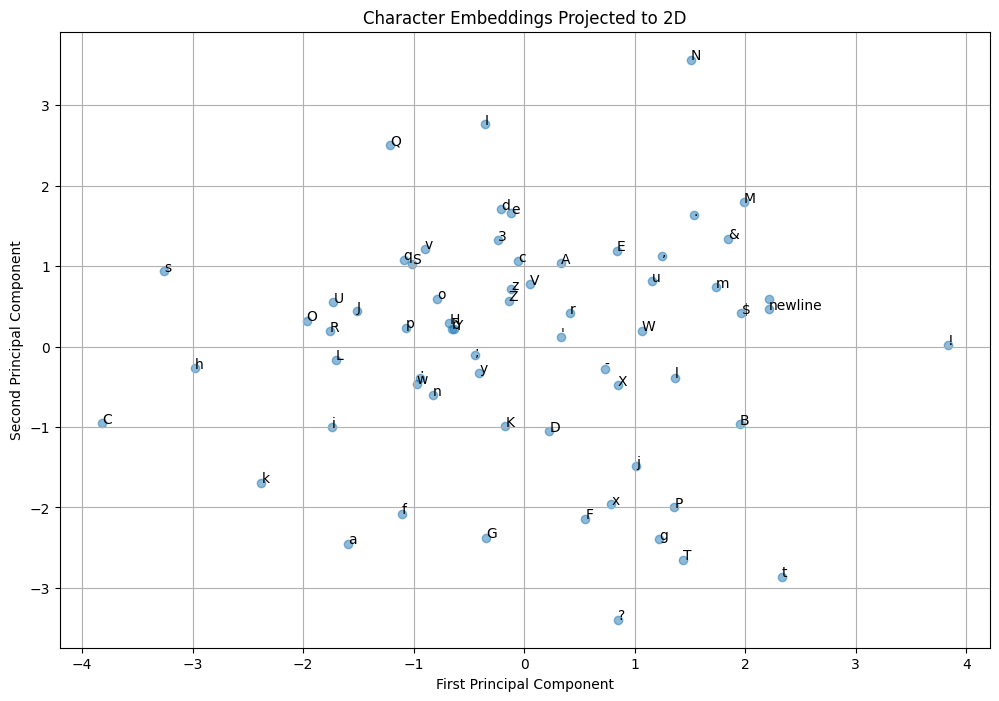

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get the embedding weights
weights = embeddings.weight.detach().numpy()

# Project to 2D using PCA
pca = PCA(n_components=2)
projected = pca.fit_transform(weights)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(projected[:, 0], projected[:, 1], alpha=0.5)

# Add character labels
for i, char in enumerate(chars):
    if char == '\n': char = 'newline'  # Make newline visible
    plt.annotate(char, (projected[i, 0], projected[i, 1]))

plt.title('Character Embeddings Projected to 2D')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.grid(True)
plt.show()

# Train Embedding function

In [38]:
import torch.nn as nn
import torch.nn.functional as F

class CharacterEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)
    
    def forward(self, center_chars, context_chars):
        # center_chars shape: [batch_size]
        # context_chars shape: [batch_size, context_size*2]
        
        # Get embeddings
        center_embeds = self.embeddings(center_chars)  # [batch_size, embedding_dim]
        context_embeds = self.context_embeddings(context_chars)  # [batch_size, context_size*2, embedding_dim]
        
        # Reshape center embeddings to [batch_size, 1, embedding_dim]
        center_embeds = center_embeds.unsqueeze(1)
        
        # Compute dot product between center and each context embedding
        # Result shape: [batch_size, 1, context_size*2]
        scores = torch.bmm(center_embeds, context_embeds.transpose(1, 2))
        
        # Remove the extra dimension: [batch_size, context_size*2]
        scores = scores.squeeze(1)
        
        return scores

# Model parameters
embedding_dim = 64
context_size = 4  # Number of characters before and after
batch_size = 256

# Initialize model
model = CharacterEmbedding(vocab_size, embedding_dim)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()  # Changed loss function

print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')

Model parameters: 8,320


In [39]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

class SkipgramDataset(Dataset):
    def __init__(self, data, context_size):
        self.data = data
        self.context_size = context_size
        self.pairs = []
        
        # Create training pairs
        for i in range(context_size, len(data) - context_size):
            center = data[i]
            context = torch.cat([
                data[i-context_size:i],
                data[i+1:i+context_size+1]
            ])
            self.pairs.append((center, context))
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        center, context = self.pairs[idx]
        return center, context

# Create dataset and dataloader
dataset = SkipgramDataset(data, context_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f'Number of training examples: {len(dataset):,}')
print(f'Number of batches: {len(dataloader):,}')

Number of training examples: 1,115,386
Number of batches: 4,357


In [40]:
from tqdm.notebook import tqdm

def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    
    for center, context in tqdm(dataloader, desc='Training'):
        # Forward pass
        scores = model(center, context)
        
        # Create target: 1 for actual context characters
        target = torch.ones_like(scores)
        
        # Calculate loss
        loss = criterion(scores, target)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

# Training parameters
n_epochs = 5

# Train the model
losses = []
for epoch in range(n_epochs):
    loss = train_epoch(model, dataloader, optimizer, criterion)
    losses.append(loss)
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss:.4f}')

Training:   0%|          | 0/4357 [00:00<?, ?it/s]

Epoch 1/5, Loss: 21.4564


Training:   0%|          | 0/4357 [00:00<?, ?it/s]

Epoch 2/5, Loss: 16.6840


Training:   0%|          | 0/4357 [00:00<?, ?it/s]

Epoch 3/5, Loss: 16.6397


Training:   0%|          | 0/4357 [00:00<?, ?it/s]

Epoch 4/5, Loss: 16.6367


Training:   0%|          | 0/4357 [00:00<?, ?it/s]

Epoch 5/5, Loss: 16.6361


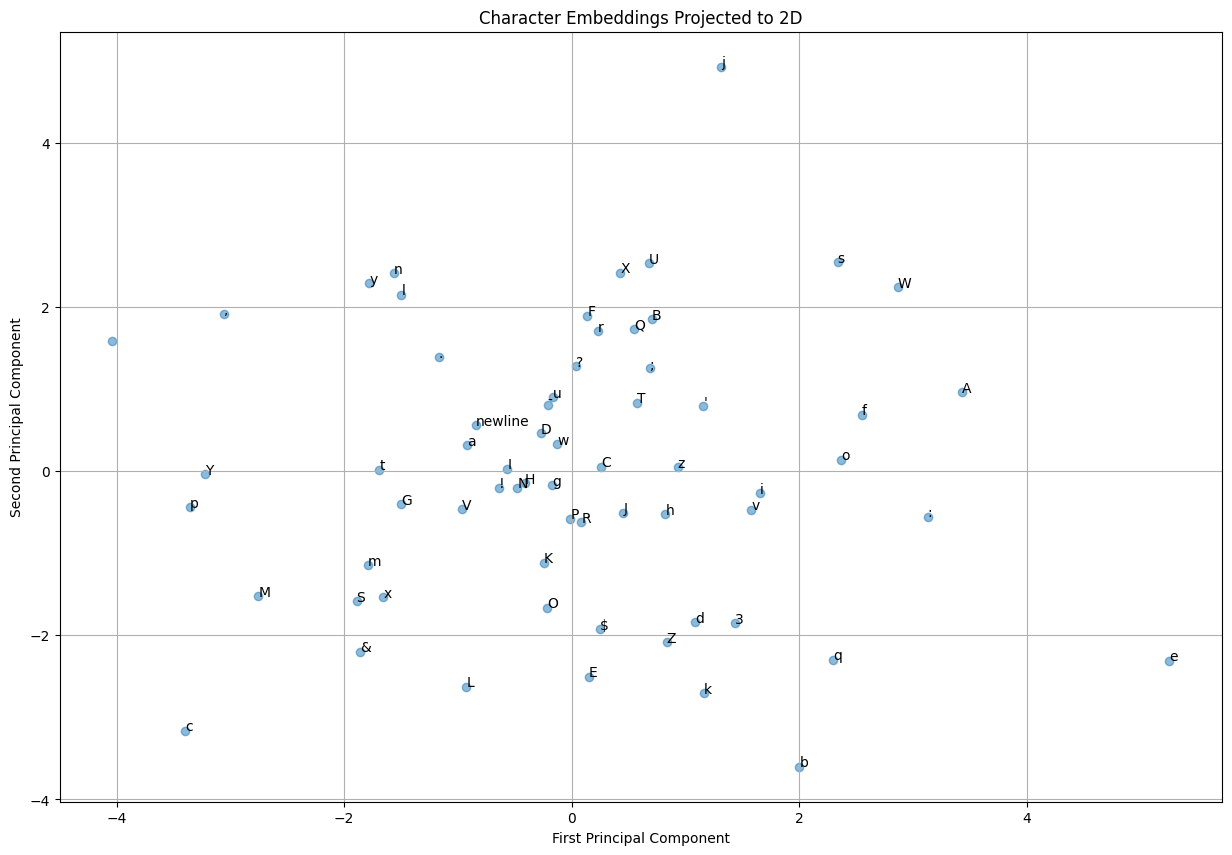


Characters most similar to "a":
"S": 0.233
"C": 0.223
"b": 0.219
"B": 0.206
"A": 0.191

Characters most similar to "A":
"C": 0.223
"j": 0.200
"A": 0.191
"3": 0.170
"x": 0.156

Characters most similar to ".":
"B": 0.206
"i": 0.202
"'": 0.177
"3": 0.170
"L": 0.163

Characters most similar to " ":
"S": 0.233
"b": 0.219
"B": 0.206
"i": 0.202
"j": 0.200


In [42]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get the trained embeddings (we use the main embeddings, not the context ones)
trained_embeddings = model.embeddings.weight.detach().numpy()

# Project to 2D using PCA
pca = PCA(n_components=2)
projected = pca.fit_transform(trained_embeddings)

# Plot
plt.figure(figsize=(15, 10))
plt.scatter(projected[:, 0], projected[:, 1], alpha=0.5)

# Add character labels
for i, char in enumerate(chars):
    if char == '\n': char = 'newline'  # Make newline visible
    plt.annotate(char, (projected[i, 0], projected[i, 1]))

plt.title('Character Embeddings Projected to 2D')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.grid(True)
plt.show()

# Function to find similar characters
def get_similar_chars(char, n=5):
    char_idx = char_to_idx[char]
    char_embedding = trained_embeddings[char_idx]
    
    # Calculate cosine similarities
    similarities = torch.nn.functional.cosine_similarity(
        torch.tensor(char_embedding),
        torch.tensor(trained_embeddings),
        dim=0
    )
    
    # Get top similar characters (excluding the character itself)
    top_indices = similarities.argsort(descending=True)[1:n+1]
    return [(idx_to_char[idx.item()], similarities[idx].item()) for idx in top_indices]

# Check some interesting characters
for char in ['a', 'A', '.', ' ']:
    print(f'\nCharacters most similar to "{char}":')
    for similar_char, similarity in get_similar_chars(char):
        print(f'"{similar_char}": {similarity:.3f}')

# Train a model to produce Text

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class CharacterLM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x):
        # x shape: (batch_size, sequence_length)
        embedded = self.embeddings(x)  # (batch_size, sequence_length, embedding_dim)
        lstm_out, _ = self.lstm(embedded)  # (batch_size, sequence_length, hidden_dim)
        logits = self.fc(lstm_out)  # (batch_size, sequence_length, vocab_size)
        return logits

# Model parameters
embedding_dim = 16
hidden_dim = 32
context_length = 16
batch_size = 128

# Initialize model
model = CharacterLM(vocab_size, embedding_dim, hidden_dim)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')

Model parameters: 9,585


In [22]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, data, context_length):
        self.data = data
        self.context_length = context_length
    
    def __len__(self):
        return len(self.data) - self.context_length - 1
    
    def __getitem__(self, idx):
        # Get input sequence and target
        x = self.data[idx:idx + self.context_length]
        y = self.data[idx + 1:idx + self.context_length + 1]
        return x, y

# Create dataset and dataloader
dataset = TextDataset(data, context_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f'Number of training examples: {len(dataset):,}')
print(f'Number of batches: {len(dataloader):,}')

Number of training examples: 1,115,377
Number of batches: 8,714


In [23]:
from tqdm.notebook import tqdm

def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    
    for x, y in tqdm(dataloader, desc='Training'):
        # Forward pass
        logits = model(x)
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

# Training parameters
n_epochs = 5

# Train the model
losses = []
for epoch in range(n_epochs):
    loss = train_epoch(model, dataloader, optimizer, criterion)
    losses.append(loss)
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss:.4f}')

Training:   0%|          | 0/8714 [00:00<?, ?it/s]

Epoch 1/5, Loss: 2.1008


Training:   0%|          | 0/8714 [00:00<?, ?it/s]

Epoch 2/5, Loss: 1.8883


Training:   0%|          | 0/8714 [00:00<?, ?it/s]

Epoch 3/5, Loss: 1.8535


Training:   0%|          | 0/8714 [00:00<?, ?it/s]

Epoch 4/5, Loss: 1.8369


Training:   0%|          | 0/8714 [00:00<?, ?it/s]

KeyboardInterrupt: 

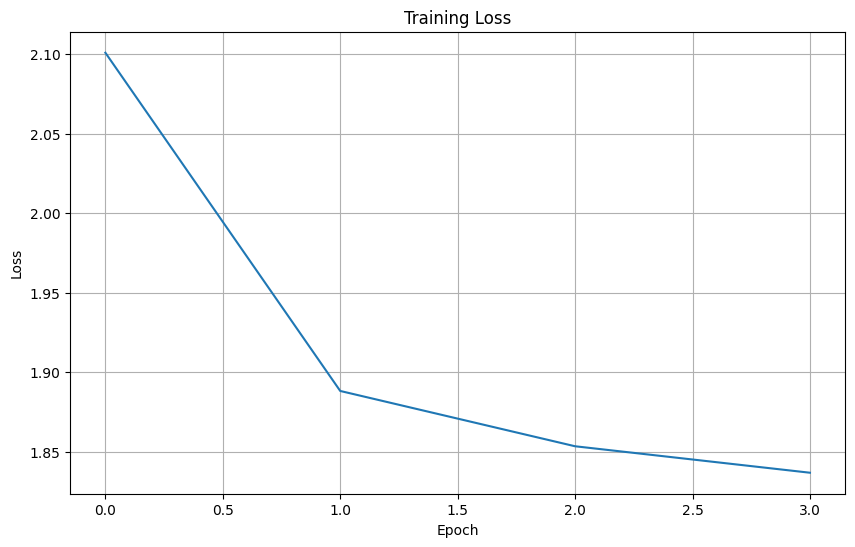

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [25]:
@torch.no_grad()
def generate_text(model, start_text, max_length=200, temperature=1.0):
    model.eval()
    
    # Convert start text to indices
    context = torch.tensor([char_to_idx[ch] for ch in start_text])
    generated_text = start_text
    
    for _ in range(max_length):
        # Get model predictions
        x = context[-context_length:].unsqueeze(0)  # Add batch dimension
        logits = model(x)
        probs = F.softmax(logits[0, -1] / temperature, dim=0)
        
        # Sample next character
        next_idx = torch.multinomial(probs, 1).item()
        next_char = idx_to_char[next_idx]
        
        # Update context and generated text
        generated_text += next_char
        context = torch.cat([context, torch.tensor([next_idx])])
    
    return generated_text

# Generate some text
start_texts = [
    "To be, or not to be",
    "Romeo, Romeo",
    "Friends, Romans, countrymen"
]

for start_text in start_texts:
    print(f'\nPrompt: "{start_text}"')
    print('Generated:')
    print(generate_text(model, start_text, temperature=0.8))
    print('-' * 80)


Prompt: "To be, or not to be"
Generated:
To be, or not to bear of it say.

CILINA:
Priven and me heart no these but fear us faked mast I wonle king.

Mursend I ELLIZAn:
What bithaping she liet as him contounce,
The be be soner take with am conglion that a thou
--------------------------------------------------------------------------------

Prompt: "Romeo, Romeo"
Generated:
Romeo, Romeo my enall not dember caunces,
God sceerpown,
A mave him,
The leave.

Hell:
Hold cannot maken my lised?
In stoul shall nock me that onh for the Way, be stands with that not not guesed
Hnend with with y
--------------------------------------------------------------------------------

Prompt: "Friends, Romans, countrymen"
Generated:
Friends, Romans, countrymen of sursender, no maition, turseance say that mains: I sfome of than in dess he inpore.
Go, I am plade the upon of me sir, not not dencat that me many to you thing the was flast thee hersince, wish be
--------------------------------------------------